# Fractal Image Compression

[Fractal image compression](https://en.wikipedia.org/wiki/Fractal_compression) is a rarely used form of image compression these days. Although it is superseded by compression approaches that are more effective in exploiting perceptual redundancy, the ideas behind it and elegant an appealing and rarely talked about these days.

* TL;DR: The reason it isn't widely used is that it doesn't work very well. It is both *extrodinarily* computationally intensive and fairly poor in terms of perceptual quality/compression ratio tradeoffs.. 

The promise of fractal image compression was high (though lossy) compression ratios and *resolution-independence*. Images are encoded as a process which converges to a pattern that has "unlimited detail", in the sense that the encoded pattern doesn't directly depend on the pixels sampled in the original image, and can be evaluated on a grid of any resolution. This is less impressive in practice than it sounds; all images can be represented in a resolution-independent way even with standard signal processing approaches; linear, cubic or sinc interpolation just make different assumptions about the continuous function that represents the underlying image. While fractal image compression can produce a more convincing level of detail than traditional interpolation in certain cases, it cannot magically conjure unseen details from an image.

## History

Fractal image compression was proposed by [Michael Barnsley](https://en.wikipedia.org/wiki/Michael_Barnsley), and subsequently [patented](https://patents.google.com/patent/US4941193) in the late 1980's. Several companies have subsequently tried to commericialise the algorithm, starting with Barnsley's company [*Iterated Systems, Inc.*](), which subsequently was renamed *Media Bin* before being bought out in the early 2000's. This led to the development of the FIF image format, a practical compressed format for images, famously used by Microsoft Encarta to store images. A discussion of the commercialisation history and the problems with fractal image compression approaches [can be read in Paul Schlessinger's blog](https://paulschlessinger.wordpress.com/2014/04/).


### References

* [Pierre's implementation](https://pvigier.github.io/2018/05/14/fractal-image-compression.html)
* [Yuval Fisher's course notes](https://karczmarczuk.users.greyc.fr/matrs/Dess/RADI/Refs/fractal_paper.pdf), the first paper I ever saw on fractal image compression.


### Iterated Function Systems, IFS
Fractal image compression was based on Barnsley's research into *iterated function systems* (IFS) -- where repeated (usually linear) transforms are applied to resolve a fixed point set. Remarkably, even if the transforms are applied in any random order, and with any initial starting point, the same fixed point can be found via repeated iteration. This holds and as long as each of the transforms is *contractive*, i.e. it maps a domain to a smaller range. That is, we define a stochastic process whose stationary distribution is the pattern representing the image.


In [19]:
import skimage.io, skimage.data, skimage.transform, skimage.transform
import numpy as np 
import scipy.signal as sig 
import IPython.display
from PIL import Image, ImageDraw
from io import BytesIO
import matplotlib.pyplot as plt
import random

#### The Barnsley fern
The most famous IFS is the Barnsley Fern, consisting of four affine transforms. Choosing any random point, then randomly applying one of these transforms, feeding that back as the next input, and so on, produces the IFS. This produces a very life-like ferm from a very simple set of rules. Thus the inspiration for fractal image compression -- if a whole fern can be packed down into 28 numbers, perhaps natural images can be compressed in a similar way?

The code below shows how an IFS can be implemented, with the Barnsley fern coefficients as an example:

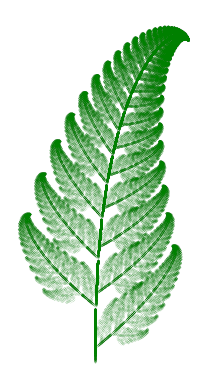

In [236]:
def weighted_random(choices, weights):
    return random.choices(choices, weights=weights, k=1)[0]

def hom_transform(transform, pt):
    # we use homogenous coordinates, so we add a 1 to the end of each point
    return transform @ np.concatenate([pt, [1]])[:3]     

def ifs(transforms, weights, n):    
    pt = np.array([0,0])
    pts = []
    for i in range(n):
        # randomly choose a transform and apply it        
        pt = hom_transform(weighted_random(transforms, weights), pt)
        pts.append(pt)
    return np.array(pts)

def homogenous(t):    
    """Create a homogenous transformation matrix from a 2x3 matrix."""
    t = np.array(t)
    h = np.zeros((3,3))
    h[-1,-1] = 1
    h[:2,:2] = t[:2,:2]
    h[:2,2] = t[2]
    return h         

# The "fern" transfomation matrices (slightly tweaked)
# (each is a 2x2 linear transform + a 2d translation)
fern = np.array([
    homogenous([[0.86, 0.04], [-0.09, 0.85], [0.0, 1.6]]),
    homogenous([[0.2, -0.26], [0.23, 0.22], [0.0, 1.6]]),
    homogenous([[-0.15, 0.28], [0.26, 0.24], [0.0, 0.44]]),
    homogenous([[0.0, 0.0], [0.0, 0.16], [0.0, 0.0]])])

# The weights for each transformation
# (higher weight means more likely to be chosen)
fern_weights = [0.85, 0.07, 0.07, 0.03]

fig, ax = plt.subplots()
ax.set_aspect('equal')
# turn off axes
ax.axis('off')
pts = ifs(fern, fern_weights, 150_000)
ax.scatter(pts[:,0], pts[:,1], s=0.001, c='g')
    

Unfortunately, finding the right transforms is *hard*; while choosing any random set of contractive transforms yields a point set with lots of self-similar detail, it's very hard to
decide how to construct a good set of transforms that approximate a target. Here's an example of a set of random transforms and weights:

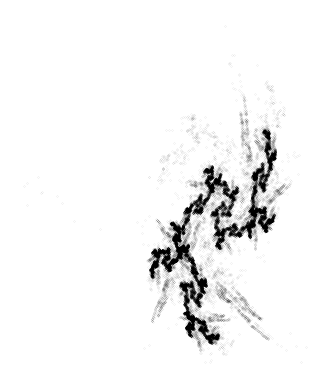

In [253]:
# Generate a random IFS
np.random.seed(2020)
n_rnd = 5

def random_transform():
    """Generate a random transform, 
    that has a (probably) contractive linear component, 
    and a random translation component."""
    t = np.zeros((3,2))
    t[:2,:2] = np.random.uniform(-1, 1,size=(2,2))*0.95
    t[2, :2] = np.random.normal(size=(2))
    return t

rnd = np.array([homogenous(random_transform()) for i in range(n_rnd)])
rnd_weights = np.random.uniform(0, 10, len(rnd))**4

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.axis('off')
pts = ifs(rnd, rnd_weights, 50_000)
ax.scatter(pts[:,0], pts[:,1], s=0.001, c='k')
    

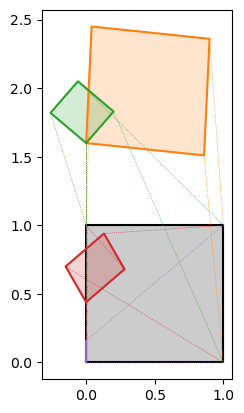

In [161]:

def box(ax, original, pts, c, alpha=1):    
    """Draw a transformed box, showing how a
    unit box is transformed by a matrix"""    
    ax.fill(pts[:,0], pts[:,1], c=c, alpha=0.2*alpha)
    ax.plot(pts[:,0], pts[:,1], c=c, alpha=alpha)
    for fr, to in zip(original, pts):
        ax.plot([fr[0], to[0]], [fr[1], to[1]], c=c, ls=':', lw=0.5, alpha=alpha)

def show_affine(ax, transforms):
    """Plot a set of homogenous affine transformations"""
    unit_box = np.array([[0,0], [1,0], [1,1], [0,1], [0,0]])
    box(ax, unit_box, unit_box, 'k')    
    colors = ["C1", "C2", "C3", "C4"]
    for i, t in enumerate(transforms):
        new_box = np.array([hom_transform(t, pt) for pt in unit_box])
        box(ax, unit_box, new_box, colors[i])        
        

fig, ax = plt.subplots()
ax.set_aspect('equal')
show_affine(ax, fern)        


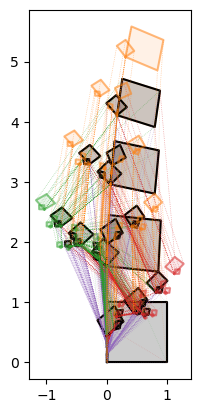

In [162]:
def show_repeated_affine(ax, initial, transforms, depth):
    """Plot a set of homogenous affine transformations, repeatedly
    applying the same set of transformations, showing the transformation "tree"."""    
    if depth<=0:
        return
    box(ax, initial, initial, 'k')    
    colors = ["C1", "C2", "C3", "C4"]
    for i, t in enumerate(transforms):
        new_box = np.array([hom_transform(t, pt) for pt in initial])
        box(ax, initial, new_box, colors[i], 1/(depth+1))     
        show_repeated_affine(ax, new_box, transforms, depth-1)

fig, ax = plt.subplots()
ax.set_aspect('equal')
show_repeated_affine(ax, np.array([[0,0], [1,0], [1,1], [0,1], [0,0]]), fern, 4)

## Fractal blocks
Finding an arbitrary IFS to represent an image is too hard. The simplification proposed by Barnsley was to only deal with fixed-size rectangular pixel blocks. We divide an image up into small blocks (e.g. 8x8 pixels); we then define a size for large blocks (e.g. 16x16 pixels). We find a contractive mapping from big blocks to small blocks, where every small block has a mapping onto it from a single larger block; the scaling is fixed (in this case a ratio of 2:1). That is, for each small block we find a large block that closely approximates it. 



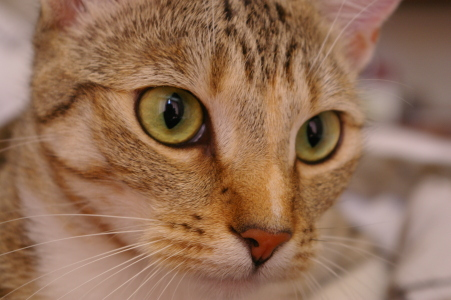

<function IPython.core.display.display(*objs, include=None, exclude=None, metadata=None, transient=None, display_id=None, **kwargs)>

In [22]:


def show_image(a, fmt="png", width="100%", label=None):
    a = np.uint8(np.clip(a, 0, 1) * 255.0)
    a = Image.fromarray(a)
    f = BytesIO()
    # add text label if given
    if label is not None:
                
        draw = ImageDraw.Draw(a)
        draw.text((10, 10), label, fill="white", anchor="mm")        
    a.save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue(), width=width))

cat = skimage.data.cat() / 255.0
show_image(cat, width="40%")
display



## Compression
Images are often represented as 2D arrays of colour values (e.g. RGB). These are large blocks of data to store and transmit, so some form of compression is almost invariably involved. Compression means modelling; and our assumption is that because images are not random, there are more parsimonious encodings than a simple listing of pixel values. The form of the parsimony depends on what we want to achieve; lossless compression aims to recover the pixel array exactly, by predicting patterns that occur more frequently and giving those short codes. Lossy compression aims to reproduce images which are perceptually similar, but not identical to the input, by mapping patterns that appear similar to the human perceptual system onto short codes. 

### Lossless sequence modelling
One approach is to treat the images as a long sequence of pixel values, "unravelling" the 2D structure and ignoring proximity of one row to the next (or in some cases, representing only the current and previous row, to preserve some adjacency information).
This often used in many *lossless* compression algorithms, like basic run-length encoding, or the more sophisticated encoding used in PNG compression. This class of algorithm use some form of entropy coding to encode the pixel sequence efficiently by modelling common sequences (e.g. repeating patterns). Most such algorithms operate naturally on sequences, so a raster-wise unravelling is logical.


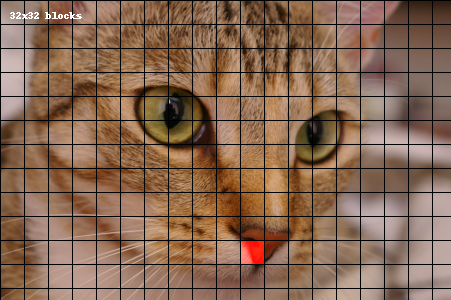

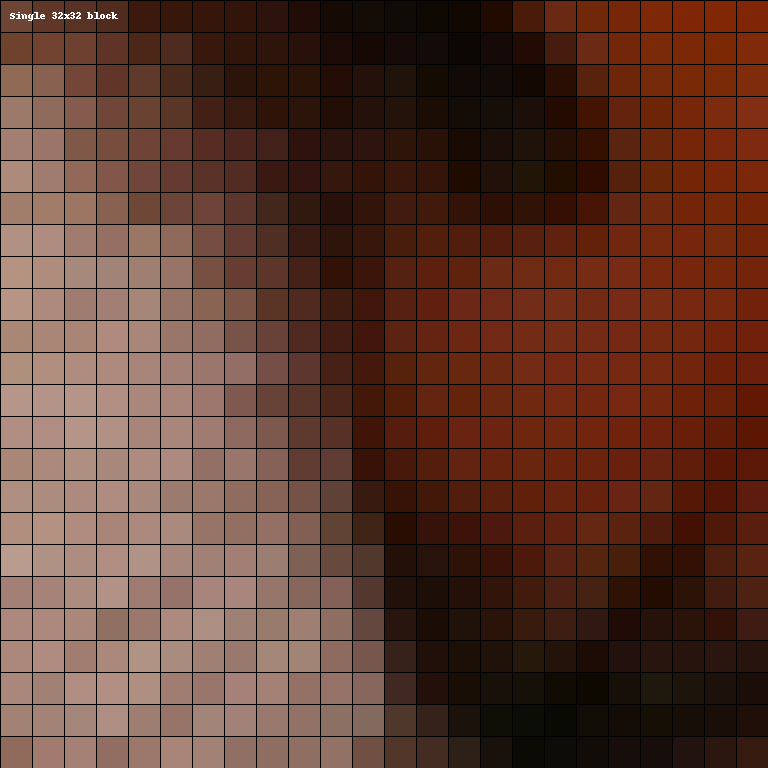

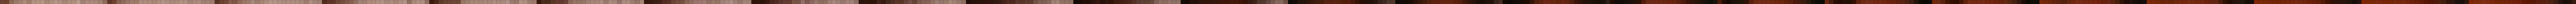

In [27]:
def show_blocks(img, n):  
    img = np.array(img)
    img[::n] = 0
    img[:,::n] = 0
    return img 

def scale_img(img, n):
    img = skimage.transform.rescale(img, (n, n, 1), order=0)
    return img

def pixels(img, scale):
    return show_blocks(scale_img(img, scale), scale)
    
def raster(img):
    return (img.T.reshape(3, -1)).T[None,:,:]

def to_blocks(img, n):
    r, c, _ = img.shape
    img = img[:r-r%n, :c-c%n]    
    return skimage.util.view_as_blocks(img, block_shape=(n,n,3))

def get_block(img, block_index, block_size):
    return img[block_index[0]*block_size:(block_index[0]+1)*block_size,
               block_index[1]*block_size:(block_index[1]+1)*block_size,]

def highlight_block(img, block_index, block_size):
    img = np.array(img)
    get_block(img, block_index, block_size)[:,:,0] = 1
    return img

block_index = (10, 10)

block_size = 24
show_image(show_blocks(highlight_block(cat, block_index, block_size), block_size), width="50%", label="32x32 blocks")
cat_eye = get_block(cat, block_index, block_size)
show_image(pixels(cat_eye, 32), width="50%", label="Single 32x32 block")

show_image(pixels(raster(cat_eye), 64), width="50%")




![]()





## Lossy compression and block structure
Images for human consumption can be compressed much more aggressively if we allow some form of *loss* -- an encoded form of an image which is decoded to be *approximately* the same as the original but not exactly. Lossy compressors strive to minimise *perceptual* loss -- to make save storage by discarding information that the human visual system is insensitive to. Common approaches include reducing chroma (colour information), as eyes are more sensitive to changes in brightness than in hue, as well as simplifying the spatial patterns in the image. 

This simplification of patterns can better model redundancy if we preserve the 2D structure of the image. In doing so, we preserve the adjacency of neighbouring rows and columns and the *locality* of information. However, we still need to be able to process images of arbitrary resolution, and do so with reasonable computation and storage costs. A common approach is to divide an image into *blocks* of a fixed size (e.g. 8x8 pixels); encode those efficiently; and then represent the image as a patchwork of blocks. The spatial relation of of blocks is usually ignored in compression; the image becomes a sequence of blocks, rather than a sequence of pixels.




There is a obviously trade-off between many small blocks that represent local changes well and larger blocks with more opportunity for redundancy. 


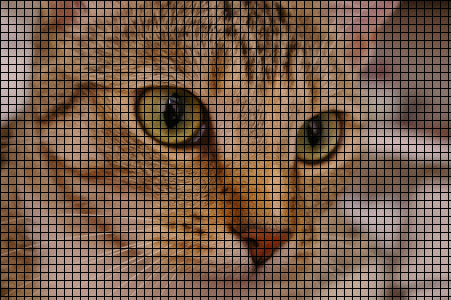

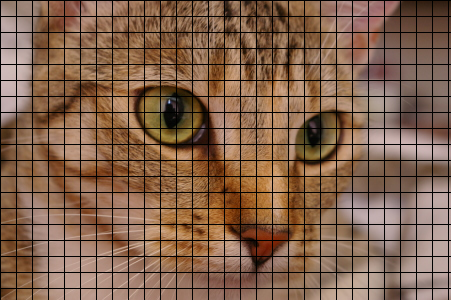

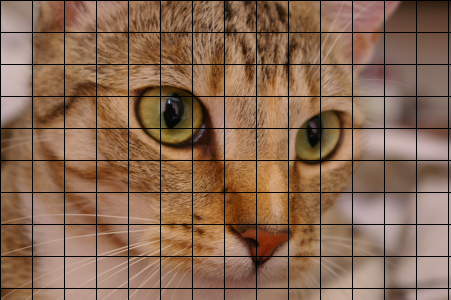

In [52]:

show_image(show_blocks(cat, 8), width="30%");
show_image(show_blocks(cat, 16), width="30%");
show_image(show_blocks(cat, 32), width="30%");



![]() 

Some algorithms can vary block size across an image, but most common algorithms, such as the compression codec in JPEG, use a fixed, pre-defined block size.


### Simple block compression
How should we exploit redundancy in in image? One simple way is to just replace blocks with similar blocks -- ones that are a good enough match. One such approach is *vector quantization*, where we find a small collection of blocks that cover most of the variation in the image, and just copy and paste them into the image. This is done by taking each block in an input image (e.g. 8x8 pixels), unravelling it to treat at as a vector in a high-dimensional space, then applying clustering to find a fixed number of points (cluster centres) in that space. Every original vector -- each of which represents a block of pixels -- is just replaced with the nearest cluster centre. This "snap to nearest" operation is quantization, reduction of a continuous space to a discrete set of possibilities.



In [20]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
block_size = 8
n_clusters = 16
vectors = to_blocks(cat, block_size).squeeze().reshape(-1, block_size**2*3)
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vectors)
kmeans.cluster_centers_.shape

(16, 192)

We can show these clusters by projecting them into 2D space using Principal Component Analysis (PCA). This just finds an optimal "rotation" of the data before we squash it down to 2D so we can visualise it. Each block becomes a point, and each cluster centre is also shown as a (larger) point in this space:

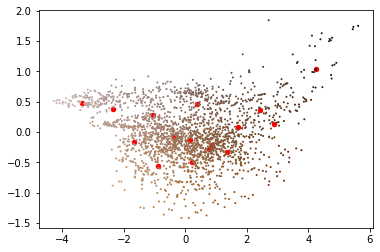

In [33]:
pca_2d = PCA(n_components=2).fit(vectors)
cluster_2d = pca_2d.transform(kmeans.cluster_centers_)
vectors_2d = pca_2d.transform(vectors)
colors = vectors.reshape(-1, 8, 8, 3).mean(axis=(1,2))
fig, ax = plt.subplots()

ax.scatter(cluster_2d[:,0], cluster_2d[:,1], s=20, alpha=1, c='r')
ax.scatter(vectors_2d[:,0], vectors_2d[:,1], s=1, c=colors)

Now we can just replace every vector with its closest cluster center, and store just the cluster centres and the indices.

In [64]:
def compress_vq(img, block_size, n_clusters):
    blocks = to_blocks(img, block_size).squeeze() # to blocks
    vectors = blocks.reshape(-1, block_size**2*3) # flatten
    kmeans = KMeans(n_clusters=n_clusters, random_state=0) # K-means
    kmeans.fit(vectors)
    return kmeans.predict(vectors), kmeans.cluster_centers_,blocks.shape

def decompress_vq(indices, cluster_centres, block_shape):    
    vectors = cluster_centres[indices]
    blocks = vectors.reshape(*block_shape)  # unflatten and then montage together
    return  skimage.util.montage(blocks.reshape(-1,*block_shape[2:]), multichannel=True, grid_shape=block_shape[0:2])


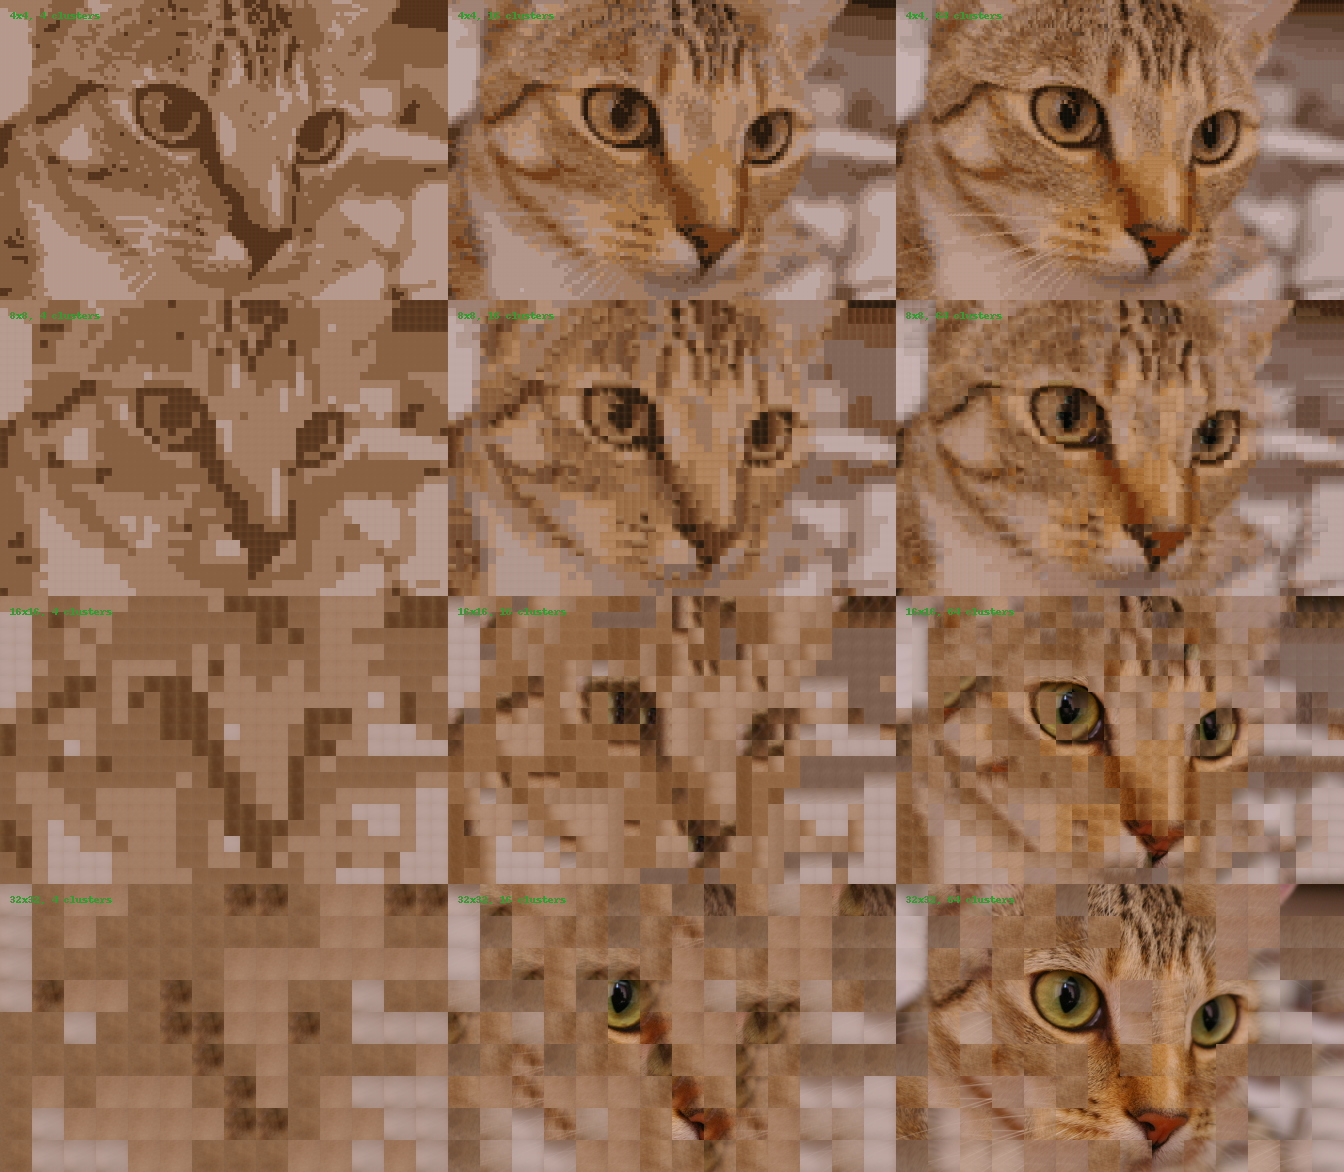

In [77]:
from PIL import Image, ImageDraw 

# put a label on the images, using PIL
def label_image(img, pos, text, color=(50,155,50)):
    img = np.array(img)
    img = Image.fromarray(np.uint8(np.clip(img, 0, 1) * 255.0))
    draw = ImageDraw.Draw(img)
    draw.text(pos, text, fill=color)
    return np.array(img) / 255.0

rows = []
for block_size in [4, 8, 16, 32]:
    cols = []
    for n_clusters in [4, 16, 64]:
        img = decompress_vq(*compress_vq(cat, block_size, n_clusters))
        cols.append(label_image(img, (10,10), f"{block_size}x{block_size}, {n_clusters} clusters"))
    rows.append(np.hstack(cols))
show_image(np.vstack(rows), width="100%")


### Codebooks and other schemes

To understand how this relates to compression, we need to define a concrete encoding for the data. For the VQ compresssion, we need to transfer the codebook (cluster centres) as N MxM images, followed by K integer codebook indices. 
We can encode the indices in clever ways (e.g. Huffman compression, if we think the block indices have a non-uniform distribution), but for now we can assume we just use $\log_2(N)$ bits per index. So we can define sizes for our images in bytes:

In [72]:
def size_raw_bytes(img):
    # assume 8 bits per channel
    return np.prod(img.shape) * 8

def size_vq_bytes(img, block_size, n_clusters):
    # assume 8 bits per channel
    n_bits = np.ceil(np.log2(n_clusters))
    index_bits = np.prod(img.shape)//(block_size**2) * n_bits
    codebook_bits = n_clusters*block_size**2*3*8
    return  codebook_bits + index_bits

# 16 clusters, 8x8 blocks, compression ratio
print(size_raw_bytes(cat) / size_vq_bytes(cat, block_size=8, n_clusters=16))

65.01681883709755



## Fractal image compression



In [10]:
def fi_compress(img, small_block, scale):
    img = np.array(img)
    r, c, _ = img.shape
    n = small_block * scale
    img = img[:r-r%n, :c-c%n]      
    codebook = {}
    for i in range(img.shape[0]//small_block):
        for j in range(img.shape[1]//small_block):
            block = img[i*small_block:(i+1)*small_block, j*small_block:(j+1)*small_block]
            scaled = scale_img(block, scale)
            min_diff = np.inf
            min_kl = None
            for k in range(img.shape[0]-n):
                for l in range(img.shape[1]-n):                    
                    mse = np.mean((scaled - img[k:k+n, l:l+n])**2)
                    mean_shift = np.mean(scaled - img[k:k+n, l:l+n], axis=(0,1))
                    if mse < min_diff:
                        min_diff = mse
                        min_kl = (k,l, mean_shift)
            print(min_kl)
            codebook[i,j] = min_kl        
    return codebook, img 

small_cat = cat[::2, ::2, :]
compression_map, small_cat = fi_compress(small_cat, 16, 2)

(91, 183, array([0.02424173, 0.02677696, 0.01692325]))
(0, 52, array([-0.02886412, -0.02595358,  0.00139017]))
(0, 148, array([ 0.00268076, -0.02311198, -0.00265012]))
(2, 161, array([ 0.00580193,  0.01199066, -0.02095205]))
(0, 54, array([0.0001417 , 0.00299862, 0.0102405 ]))
(10, 191, array([ 0.03566559, -0.00078891, -0.06595052]))
(10, 17, array([-0.03035769, -0.00906097,  0.00776654]))
(72, 0, array([-0.10037148, -0.07167969, -0.05403646]))
(0, 129, array([-0.07869562, -0.06638327, -0.05173866]))
(24, 22, array([-0.00909544, -0.00643765, -0.01303615]))
(0, 156, array([0.01256127, 0.02490043, 0.03860677]))
(0, 161, array([ 0.01276808, -0.00455729,  0.03393842]))
(0, 184, array([-0.05904565, -0.05743336, -0.05986137]))
(0, 191, array([-0.10851333, -0.09871706, -0.1037186 ]))
(95, 191, array([0.05904565, 0.06583946, 0.07608379]))
(2, 15, array([-0.0342716 , -0.03012025, -0.04896599]))
(7, 32, array([0.01021752, 0.01767387, 0.01765472]))
(3, 40, array([-0.02028952, -0.0212546 , -0.0322

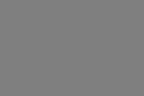

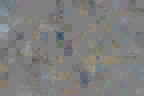

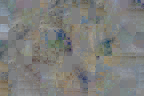

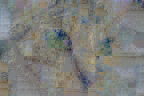

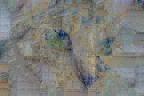

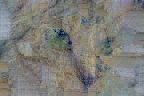

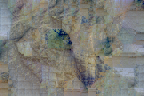

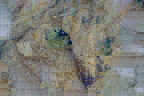

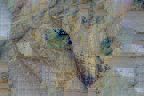

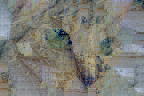

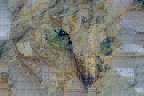

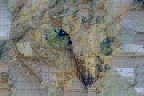

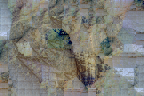

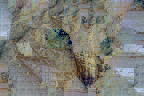

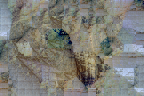

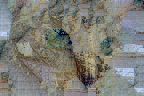

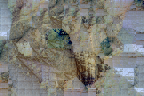

In [9]:
import random
noise = np.random.uniform(0, 1, small_cat.shape)*0+0.5
map_keys = list(compression_map.keys())
block_size = 16
for i in range(5000):
    if i%300==0:
        show_image(noise, width="30%")
    for k in compression_map.keys():
        random_key = random.choice(map_keys)
    r1, c1 = random_key
    r2, c2, shift = compression_map[random_key]
    scaled = skimage.transform.rescale(noise[r2:r2+block_size*2, c2:c2+block_size*2], (0.5,0.5,1), order=0)    
    noise[r1*block_size:(r1+1)*block_size, c1*block_size:(c1+1)*block_size] =  (scaled + shift)




### Choices and parameters 

## Neural fractal image compression


## History
### Fractal image compression
### IFS
### Barnsley
### FIF format
#### Uses


# References